In [1]:
# Imports and Environment Setup

from pathlib import Path
import sys
import os
import pandas as pd

# Environment setup
import dotenv
dotenv.load_dotenv(".env", override=True) # Defines MONGO_URI

# Local
project_root = Path.cwd().parent
src_path = str(project_root / "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from analysis.fetch import fetch_images, global_latest_scan
from analysis.remediation import fetch_remediations
from analysis.alpine import list_cgr_alpine
from analysis.stat import RemediationTable
from analysis.plot.hist import rtime_hist
from analysis.plot.timeline import rtime_timeline

In [2]:
# Collect Remediations

CSV_FILE = "remediations.csv"

if not os.path.exists(CSV_FILE):
    tab = fetch_remediations()
    tab._df.to_csv(CSV_FILE, index=False, escapechar="\\")

df = pd.read_csv(CSV_FILE)
df["first_seen_at"] = pd.to_datetime(df["first_seen_at"])
df["remediated_at"] = pd.to_datetime(df["remediated_at"])
tab = RemediationTable(df)

# Filter out Chainguard images based on alpine
OMIT_CSV = "omit.csv"

omit_df = pd.read_csv(OMIT_CSV)
for _, row in omit_df.iterrows():
    tab = tab.filter(repository=row["repository"],
                     purge=True)

print(f"Found {tab._df.shape[0]} scans ending on on {tab.latest_remediation()}")

Found 66501 scans ending on on 2024-04-30 16:04:22.591000


In [10]:
cgr_tab = tab.filter(registry="cgr.dev")
n_discovered = cgr_tab.discovered().shape[0]

cgr_tab = cgr_tab.resolve_edge_cases(remediated_at=False)
n_remediated = cgr_tab.remediated().shape[0]
rtime = cgr_tab.remediated()["rtime"].mean()

print(f"N Discovered: {n_discovered}")
print(f"N Remediated: {n_remediated}")
print(f"Mean Remediation Time: {rtime / 24:.2f} days")

Resolving edge-cases: 100%|██████████| 169/169 [00:00<00:00, 3618.94it/s]

N Discovered: 154
N Remediated: 135
Mean Remediation Time: 2.67 days


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Days', ylabel='Number of CVEs'>)

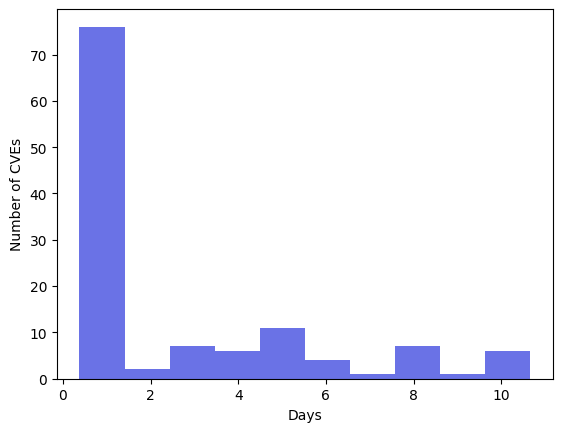

In [11]:
rtime_hist(cgr_tab)

In [ ]:
# cgr_trimmed_df = tab.filter(registry="cgr.dev")._df
# cgr_trimmed_df["repository"] = cgr_trimmed_df["repository"].str.replace("chainguard/", "")
# cgr_trimmed_df = cgr_trimmed_df[cgr_trimmed_df["repository"].isin(images)]
# cgr_trimmed_table = RemediationTable(cgr_trimmed_df)
cgr_tab = tab.filter(label="cgr-public")
rtime_timeline(cgr_tab, figsize=(7, 20),
               include_cve_ids=False)

keycloak:
    - GHSA-f8h5-v2vg-46rr (CVE-2024-2700)
        > published 15 days ago
        > fixed 6 hours ago